# Linear Regression: The Universal Pattern Finder

## Today's Mission
**Master linear regression - from simple lines to complex curves - using real-world data**


## Learning Objectives

By the end of this lecture, you will:

1. **See** how the same algorithm solves vastly different non-linear problems
2. **Understand** the linear regression model, its parameters, and the MSE loss function
3. **Master** polynomial features and basis function expansion through hands-on interaction
4. **Apply** these techniques to real problems (weather forecasting, automotive engineering)
5. **Recognize** overfitting and understand when models become too complex
6. **Build** geometric intuition through the "lifting" technique


# Part 1: The Complete Picture First

## Two Different Problems, One Mathematical Solution

Let's start by witnessing something remarkable - the same algorithm solving completely different curved relationships:

### What we'll demonstrate:
- Automotive engineering: curved efficiency relationships
- Weather forecasting: periodic daily patterns
- Both solved with the same linear regression approach
- The key: polynomial feature transformation

In [6]:
# Quietly ensure required packages are available (installs only if missing)
import importlib, sys, subprocess, os
from subprocess import DEVNULL

INCLUDE_ECMWF = True  # set False if you won't run ECMWF cells

def ensure(pkg, import_name=None, version_spec=""):
    name = import_name or pkg
    try:
        importlib.import_module(name)
    except ImportError:
        spec = pkg + (version_spec or "")
        subprocess.call([sys.executable, "-m", "pip", "install", "-q", spec],
                        stdout=DEVNULL, stderr=DEVNULL)

# Versions compatible with Python 3.9 and this lecture
base = [
    ("numpy", None, "<2"),
    ("pandas", None, ">=1.5,<2.3"),
    ("mlxtend", None, ">=0.22,<0.24"),
    ("scikit-learn", "sklearn", ">=1.3,<1.5"),
    ("matplotlib", None, ">=3.7,<3.9"),
    ("ipywidgets", None, ">=7.7,<9"),
]

ecmwf = [
    ("climetlab", None, ">=0.20"),
    ("climetlab-mltc-surface-observation-postprocessing",
     "climetlab_mltc_surface_observation_postprocessing", ">=0.3.0"),
]

for pkg, import_name, ver in base:
    ensure(pkg, import_name, ver)

if INCLUDE_ECMWF:
    for pkg, import_name, ver in ecmwf:
        ensure(pkg, import_name, ver)

# Enable ipywidgets for classic Notebook (quiet)
try:
    subprocess.call([sys.executable, "-m", "jupyter", "nbextension", "enable",
                     "--py", "widgetsnbextension", "--sys-prefix"],
                    stdout=DEVNULL, stderr=DEVNULL)
except Exception:
    pass

In [8]:
# Problem 1: Real automotive data - 398 vehicles from 1970-1982
# Load Auto MPG and keep a clean DataFrame with mpg + features
import numpy as np
import pandas as pd
from mlxtend.data import autompg_data
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

# Load features (X_auto) and target (y_auto = mpg)
X_auto, y_auto = autompg_data()

# Try to assign canonical names if shape matches; else fall back to generic
canonical_cols = ['cylinders', 'displacement', 'horsepower',
                  'weight', 'acceleration', 'model_year', 'origin']
if X_auto.shape[1] == len(canonical_cols):
    df_auto = pd.DataFrame(X_auto, columns=canonical_cols)
else:
    df_auto = pd.DataFrame(X_auto, columns=[f'feat_{i}' for i in range(X_auto.shape[1])])
    # displacement is column 1 in mlxtend's autompg features; keep a named alias for downstream cells
    df_auto['displacement'] = X_auto[:, 1]

# Attach target
df_auto['mpg'] = y_auto

# Use engine displacement as our feature (column guaranteed by branch above)
X_cars = df_auto['displacement'].to_numpy().reshape(-1, 1)
y_mpg = df_auto['mpg'].to_numpy()

print(f"Automotive dataset: {len(df_auto)} real vehicles")
print(f"Engine sizes range from {X_cars.min():.0f} to {X_cars.max():.0f} cubic inches")
print(f"MPG ranges from {y_mpg.min():.1f} to {y_mpg.max():.1f}")

Automotive dataset: 392 real vehicles
Engine sizes range from 68 to 455 cubic inches
MPG ranges from 9.0 to 46.6


In [15]:
# ECMWF plugin guard (only runs install if truly missing; avoids resolver churn)
try:
    import climetlab_mltc_surface_observation_postprocessing  # already present in your env
except Exception:
    import sys, subprocess
    from subprocess import DEVNULL
    subprocess.call([sys.executable, "-m", "pip", "install", "-q", "--no-deps",
                     "climetlab-mltc-surface-observation-postprocessing==0.3.0"],
                    stdout=DEVNULL, stderr=DEVNULL)

from sklearn import metrics
from ipywidgets import interact, FloatSlider, IntSlider, Checkbox

import climetlab as cml

# Load actual forecast errors from global weather stations
forecast_error = cml.load_dataset(
    'mltc-surface-observation-postprocessing',
    field='forecast_error'
).to_numpy()

time_of_day = cml.load_dataset(
    'mltc-surface-observation-postprocessing',
    field='time_of_day'
).to_numpy()

print(f"\nWeather dataset: {len(forecast_error):,} observations from 8,000 stations")

# Calculate BASELINE metrics for weather
baseline_rmse = np.sqrt(np.mean(forecast_error**2))
baseline_mae = np.mean(np.abs(forecast_error))
print(f"Weather baseline RMSE: {baseline_rmse:.3f}°C (before any correction)")
print(f"Weather baseline MAE: {baseline_mae:.3f}°C")

# Sample weather data for training
sample_size = 50000
idx = np.random.choice(len(forecast_error), sample_size, replace=False)
X_weather = time_of_day[idx].reshape(-1, 1)
y_weather = forecast_error[idx]


Weather dataset: 5,265,488 observations from 8,000 stations
Weather baseline RMSE: 2.254°C (before any correction)
Weather baseline MAE: 1.633°C


### The Magic: Same Algorithm, Different Problems


In [16]:
# THE SAME SOLUTION FOR BOTH REAL DATASETS
poly = PolynomialFeatures(degree=3)

# Fit to automotive data
model_car = LinearRegression().fit(
    poly.fit_transform(X_cars), y_mpg
)

# Fit to weather data  
model_weather = LinearRegression().fit(
    poly.fit_transform(X_weather), y_weather
)

# Calculate performance for automotive
car_predictions = model_car.predict(poly.transform(X_cars))
car_rmse = np.sqrt(metrics.mean_squared_error(y_mpg, car_predictions))
car_r2 = metrics.r2_score(y_mpg, car_predictions)

# Calculate performance for weather (on sample)
weather_predictions = model_weather.predict(poly.transform(X_weather))
weather_baseline_sample = np.sqrt(np.mean(y_weather**2))
weather_corrected_rmse = np.sqrt(metrics.mean_squared_error(y_weather, weather_predictions))
weather_improvement = (weather_baseline_sample - weather_corrected_rmse) / weather_baseline_sample * 100

print(f"\nSame polynomial regression algorithm (degree 3):")
print(f"  Automotive: RMSE = {car_rmse:.2f} MPG, R² = {car_r2:.3f}")
print(f"  Weather: Baseline = {weather_baseline_sample:.3f}°C → Corrected = {weather_corrected_rmse:.3f}°C")


Same polynomial regression algorithm (degree 3):
  Automotive: RMSE = 4.34 MPG, R² = 0.690
  Weather: Baseline = 2.234°C → Corrected = 2.199°C
  Weather improvement: 1.6%



### Visualizing Real Patterns in Real Data

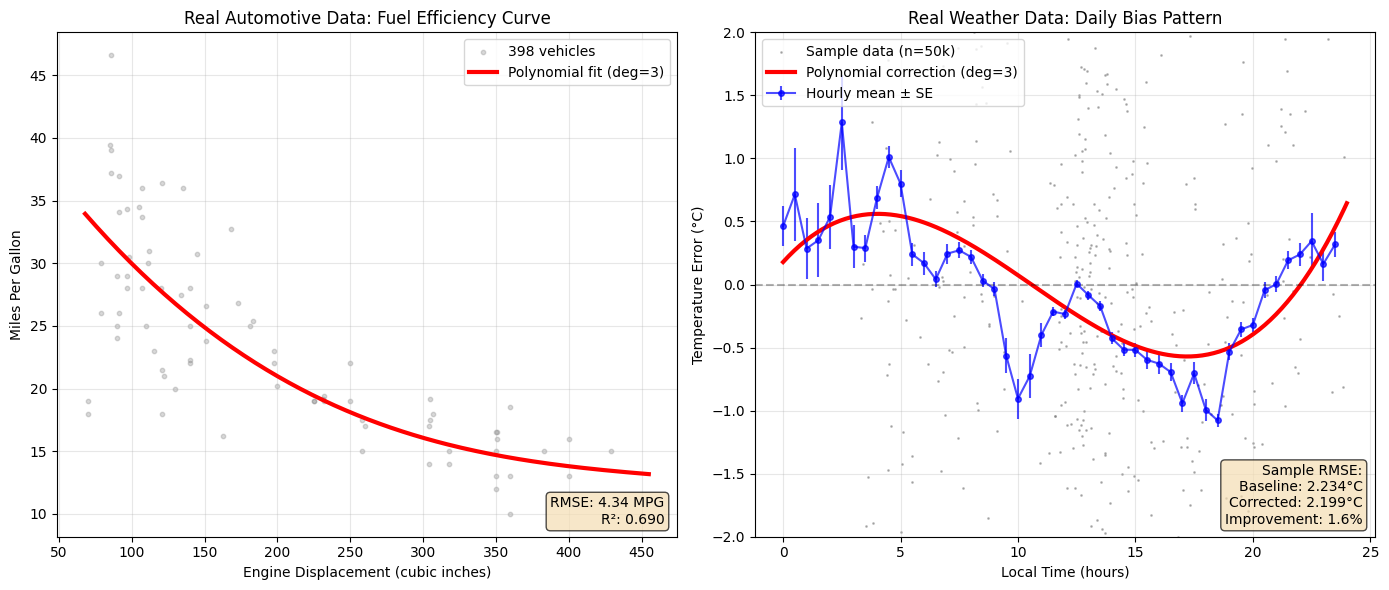

In [20]:
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Real automotive efficiency curve
axes[0].scatter(X_cars[::5], y_mpg[::5], alpha=0.3, s=10, color='gray', label='398 vehicles')
x_car_smooth = np.linspace(X_cars.min(), X_cars.max(), 200).reshape(-1, 1)
axes[0].plot(x_car_smooth, model_car.predict(poly.transform(x_car_smooth)), 
            'r-', linewidth=3, label='Polynomial fit (deg=3)')
axes[0].set_xlabel('Engine Displacement (cubic inches)')
axes[0].set_ylabel('Miles Per Gallon')
axes[0].set_title('Real Automotive Data: Fuel Efficiency Curve')
axes[0].legend()
axes[0].grid(True, alpha=0.3)
axes[0].text(0.98, 0.02, f'RMSE: {car_rmse:.2f} MPG\nR²: {car_r2:.3f}', 
            transform=axes[0].transAxes, ha='right', va='bottom',
            bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.7))

# Real weather forecast errors - show hourly pattern
# Aggregate by hour to see the mean pattern
hours = np.arange(0, 24, 0.5)
mean_errors = []
std_errors = []

for hour in hours:
    mask = (X_weather.flatten() >= hour) & (X_weather.flatten() < hour + 0.5)
    if np.sum(mask) > 0:
        mean_errors.append(np.mean(y_weather[mask]))
        std_errors.append(np.std(y_weather[mask]) / np.sqrt(np.sum(mask)))  # Standard error
    else:
        mean_errors.append(0)
        std_errors.append(0)

mean_errors = np.array(mean_errors)
std_errors = np.array(std_errors)

# Plot the weather data
axes[1].scatter(X_weather[::100], y_weather[::100], alpha=0.5, s=1, color='gray', label='Sample data (n=50k)')
axes[1].errorbar(hours, mean_errors, yerr=std_errors, fmt='o-', 
                 color='blue', alpha=0.7, markersize=4, label='Hourly mean ± SE')

# Overlay polynomial fit
x_weather_smooth = np.linspace(0, 24, 200).reshape(-1, 1)
y_weather_fit = model_weather.predict(poly.transform(x_weather_smooth))
axes[1].plot(x_weather_smooth, y_weather_fit, 'red', linewidth=3, 
            label='Polynomial correction (deg=3)')
axes[1].set_xlabel('Local Time (hours)')
axes[1].set_ylabel('Temperature Error (°C)')
axes[1].set_title('Real Weather Data: Daily Bias Pattern')
axes[1].set_ylim([-2, 2])
axes[1].legend(loc='upper left')
axes[1].grid(True, alpha=0.3)
axes[1].axhline(y=0, color='black', linestyle='--', alpha=0.3)

# Add performance box for weather
axes[1].text(0.98, 0.02, f'Sample RMSE:\nBaseline: {weather_baseline_sample:.3f}°C\nCorrected: {weather_corrected_rmse:.3f}°C\nImprovement: {weather_improvement:.1f}%', 
            transform=axes[1].transAxes, ha='right', va='bottom',
            bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.7))

plt.tight_layout()
plt.show()


### Key Insight:

**The SAME polynomial regression (degree 3) solved both problems!**
- Automotive: Captured the inverse relationship between engine size and efficiency"
- Weather: Captured the daily periodic bias in temperature forecasts"

But wait - if these are curves, *why is it called 'LINEAR' regression?*

Let's understand this paradox by building from fundamentals...


# Part 2: Building Understanding from Fundamentals

## Understanding the Basic Model

Now that we've seen the power, let's understand the fundamentals step by step.

### The Linear Model

The simplest form of linear regression:

$$y = wx + b$$

Where:
- $w$ is the **weight** (slope)
- $b$ is the **bias** (intercept)
- $x$ is the input feature
- $y$ is the prediction

### Creating Our Learning Dataset

Let's generate a controlled dataset with hidden complexity - perfect for understanding the concepts:

Dataset characteristics:
  Samples: 200
  True relationship: y = 5 + 2x - 0.3x²
  Noise level: σ = 1.5

Notice the subtle curvature - a linear model will struggle with this!


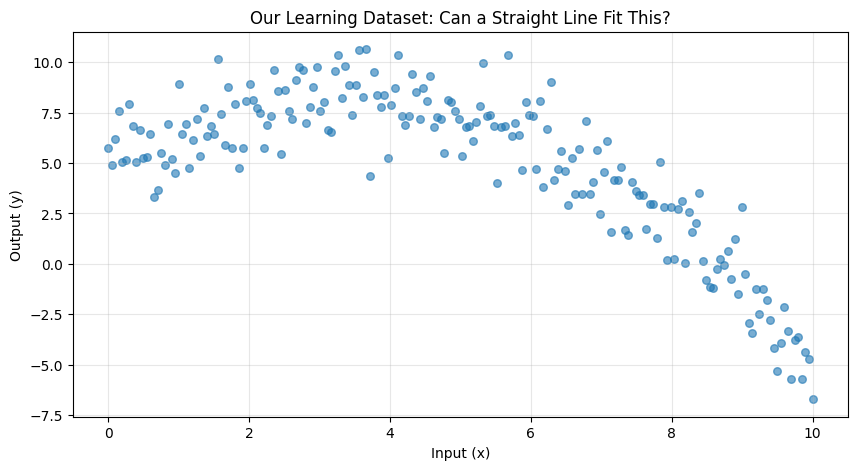

In [21]:
# Generate synthetic data with hidden quadratic relationship
np.random.seed(42)
n_samples = 200

# Create data with a subtle curve (quadratic with noise)
X_learn = np.linspace(0, 10, n_samples)
true_relationship = 5 + 2*X_learn - 0.3*X_learn**2  # Quadratic truth
y_learn = true_relationship + np.random.normal(0, 1.5, n_samples)  # Add noise

# Split for later use
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(
    X_learn.reshape(-1, 1), y_learn, test_size=0.3, random_state=42
)

# Initial visualization
plt.figure(figsize=(10, 5))
plt.scatter(X_learn, y_learn, alpha=0.6, s=30)
plt.xlabel('Input (x)')
plt.ylabel('Output (y)')
plt.title('Our Learning Dataset: Can a Straight Line Fit This?')
plt.grid(True, alpha=0.3)

print("Dataset characteristics:")
print(f"  Samples: {n_samples}")
print(f"  True relationship: y = 5 + 2x - 0.3x²")
print(f"  Noise level: σ = 1.5")
print("\nNotice the subtle curvature - a linear model will struggle with this!")

## The Mean Squared Error (MSE) Loss Function

### Mathematical Definition

The MSE measures how wrong our predictions are:

$$\text{MSE} = \frac{1}{n} \sum_{i=1}^{n} (y_i - \hat{y}_i)^2$$

Where:
- $y_i$ is the actual value
- $\hat{y}_i = wx_i + b$ is our prediction
- $n$ is the number of samples

### Computing MSE Manually

Let's implement MSE calculation from scratch to truly understand it:

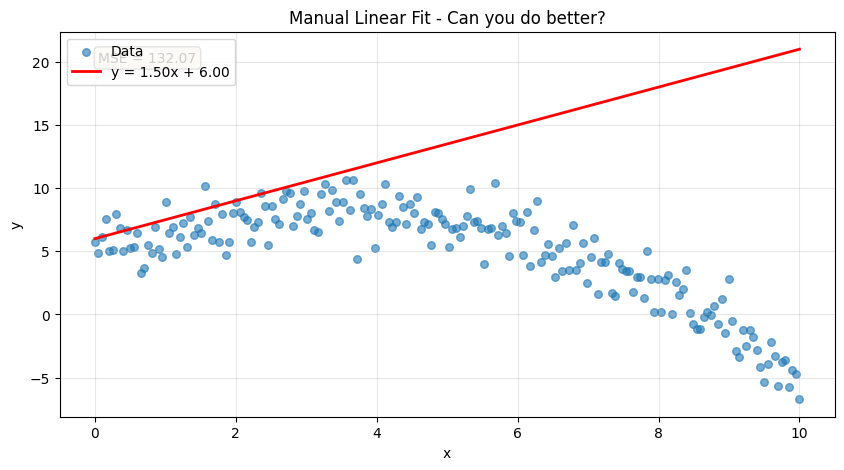

Manual MSE: 132.07
This is just our guess - let's find the optimal parameters interactively!


In [22]:
def calculate_mse(X, y, w, b):
    """
    Calculate Mean Squared Error for linear model y = wx + b
    """
    predictions = w * X + b
    squared_errors = (y - predictions) ** 2
    mse = np.mean(squared_errors)
    return mse

def plot_linear_fit(X, y, w, b, title="Linear Model Fit"):
    """Visualize linear model and its fit"""
    plt.figure(figsize=(10, 5))
    plt.scatter(X, y, alpha=0.6, s=30, label='Data')
    
    X_line = np.linspace(X.min(), X.max(), 100)
    y_line = w * X_line + b
    plt.plot(X_line, y_line, 'r-', linewidth=2, 
             label=f'y = {w:.2f}x + {b:.2f}')
    
    # Add MSE to plot
    mse = calculate_mse(X, y, w, b)
    plt.text(0.05, 0.95, f'MSE = {mse:.2f}', 
            transform=plt.gca().transAxes,
            bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5),
            verticalalignment='top')
    
    plt.xlabel('x')
    plt.ylabel('y')
    plt.title(title)
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.show()
    
    return mse

# Try manual parameters
w_manual = 1.5
b_manual = 6.0
mse_manual = plot_linear_fit(X_learn, y_learn, w_manual, b_manual, 
                             "Manual Linear Fit - Can you do better?")
print(f"Manual MSE: {mse_manual:.2f}")
print("This is just our guess - let's find the optimal parameters interactively!")

## Interactive Parameter Exploration

### Tune parameters yourself and watch MSE change in real-time:

In [31]:
def interactive_linear_regression_improved(w=1.0, b=5.0, show_optimal=False):
    """Interactive visualization with 2D MSE contour plot"""
    
    fig, axes = plt.subplots(1, 2, figsize=(13, 5))
    
    # Calculate MSE for current parameters
    mse_current = calculate_mse(X_learn, y_learn, w, b)
    
    # Main plot (same as before)
    axes[0].scatter(X_learn, y_learn, alpha=0.4, s=30, label='Data')
    
    X_line = np.linspace(X_learn.min(), X_learn.max(), 100)
    y_line = w * X_line + b
    axes[0].plot(X_line, y_line, 'r-', linewidth=2, 
                 label=f'Your model: y = {w:.2f}x + {b:.2f}')
    
    if show_optimal:
        y_optimal_line = w_optimal * X_line + b_optimal
        axes[0].plot(X_line, y_optimal_line, 'g--', linewidth=2, alpha=0.7,
                    label=f'Optimal: y = {w_optimal:.2f}x + {b_optimal:.2f}')
    
    mse_text = f'Your MSE: {mse_current:.2f}'
    if show_optimal:
        mse_text += f'\nOptimal MSE: {mse_optimal:.2f}'
    
    axes[0].text(0.05, 0.95, mse_text, transform=axes[0].transAxes,
                bbox=dict(boxstyle='round', 
                         facecolor='lightgreen' if mse_current < mse_optimal + 1 else 'wheat'),
                verticalalignment='top')
    
    axes[0].set_xlabel('x')
    axes[0].set_ylabel('y')
    axes[0].set_title('Adjust Parameters to Minimize MSE')
    axes[0].legend()
    axes[0].grid(True, alpha=0.3)
    
    # 2D MSE Contour Plot - EXPANDED RANGE
    w_range = np.linspace(-5, 8, 60)  # Expanded from [-1, 4]
    b_range = np.linspace(-5, 20, 60)  # Expanded from [0, 12]
    W, B = np.meshgrid(w_range, b_range)
    
    # Calculate MSE for all combinations
    MSE = np.zeros_like(W)
    for i in range(len(b_range)):
        for j in range(len(w_range)):
            MSE[i, j] = calculate_mse(X_learn, y_learn, W[i, j], B[i, j])
    
    # Create contour plot with more levels for better visualization
    levels = np.logspace(np.log10(mse_optimal), np.log10(mse_optimal * 50), 30)
    contour = axes[1].contour(W, B, MSE, levels=levels, cmap='viridis', alpha=0.6)
    axes[1].clabel(contour, inline=True, fontsize=7, fmt='%.0f')
    
    # Mark current position
    axes[1].scatter([w], [b], color='red', s=200, marker='X', 
                   zorder=5, label=f'Current: ({w:.1f}, {b:.1f})')
    
    # Mark optimal position
    axes[1].scatter([w_optimal], [b_optimal], color='green', s=200, 
                   marker='*', zorder=5, label=f'Optimal: ({w_optimal:.1f}, {b_optimal:.1f})')
    
    # Draw path from current to optimal
    if show_optimal:
        axes[1].arrow(w, b, 
                     (w_optimal - w) * 0.8, (b_optimal - b) * 0.8,
                     head_width=0.2, head_length=0.1, 
                     fc='yellow', ec='yellow', alpha=0.5, zorder=4)
    
    axes[1].set_xlabel('Weight (w)')
    axes[1].set_ylabel('Bias (b)')
    axes[1].set_title('MSE Landscape (Complete View)')
    axes[1].legend(loc='upper right')
    axes[1].grid(True, alpha=0.3)
    axes[1].set_xlim([-4, 4])  # Match the expanded range
    axes[1].set_ylim([-5, 20])  # Match the expanded range
    
    plt.tight_layout()
    plt.show()
    
    if mse_current < mse_optimal + 0.5:
        print("Excellent! You're very close to optimal!")
    else:
        distance = np.sqrt((w - w_optimal)**2 + (b - b_optimal)**2)
        print(f"Distance from optimal: {distance:.2f}")
        print("Try to reach the center of the contour circles!")

# Create interactive widget with EXPANDED SLIDER RANGES
print("🎯 Challenge: Navigate to the minimum of the MSE surface!")
print("The contour plot shows the complete landscape - find the valley!\n")
interact(interactive_linear_regression_improved,
         w=FloatSlider(min=-5, max=8, step=0.1, value=1.0, description='Weight (w):'),
         b=FloatSlider(min=-5, max=20, step=0.5, value=5.0, description='Bias (b):'),
         show_optimal=Checkbox(value=False, description='Show Optimal'))

🎯 Challenge: Navigate to the minimum of the MSE surface!
The contour plot shows the complete landscape - find the valley!



interactive(children=(FloatSlider(value=1.0, description='Weight (w):', max=8.0, min=-5.0), FloatSlider(value=…

<function __main__.interactive_linear_regression_improved(w=1.0, b=5.0, show_optimal=False)>

### Learning Through Interaction:
By adjusting parameters, you can see how MSE changes and develop intuition about optimization. Notice how there's a unique minimum in the MSE landscape!


## Revealing the Problem: Linear Models Miss Curves

### Let's see why we need polynomial features:

⚠️ The U-shaped residual pattern reveals our linear model is missing curved structure!
This motivates polynomial features...


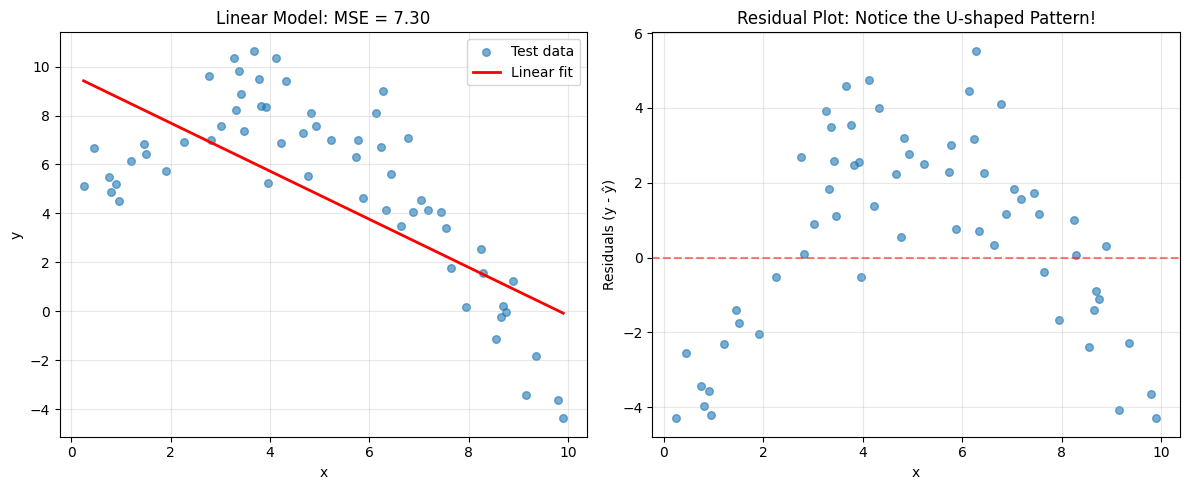

In [26]:
# Fit optimal linear model
linear_model_simple = LinearRegression()
linear_model_simple.fit(X_train, y_train)
y_linear = linear_model_simple.predict(X_test)

# Visualize with residuals
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Fit plot
axes[0].scatter(X_test, y_test, alpha=0.6, s=30, label='Test data')
sort_idx = np.argsort(X_test.flatten())
axes[0].plot(X_test[sort_idx], y_linear[sort_idx], 'r-', linewidth=2, label='Linear fit')
axes[0].set_xlabel('x')
axes[0].set_ylabel('y')
axes[0].set_title(f'Linear Model: MSE = {metrics.mean_squared_error(y_test, y_linear):.2f}')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Residual plot - THE KEY INSIGHT
residuals = y_test - y_linear
axes[1].scatter(X_test, residuals, alpha=0.6, s=30)
axes[1].axhline(y=0, color='r', linestyle='--', alpha=0.5)
axes[1].set_xlabel('x')
axes[1].set_ylabel('Residuals (y - ŷ)')
axes[1].set_title('Residual Plot: Notice the U-shaped Pattern!')
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
print("⚠️ The U-shaped residual pattern reveals our linear model is missing curved structure!")
print("This motivates polynomial features...")

# Part 3: The Polynomial Solution

## Key Concept: Linear in Parameters

Instead of: $y = \theta_0 + \theta_1 x$

We use: $y = \theta_0 + \theta_1 x + \theta_2 x^2 + \theta_3 x^3$

**This is still linear regression** because the model is linear in the parameters $\theta$.

### Interactive Polynomial Degree Exploration

In [27]:
from sklearn.pipeline import Pipeline

def explore_polynomial_fit(degree=1):
    """Interactive visualization of polynomial regression"""
    
    # Fit polynomial model
    poly_model = Pipeline([
        ('poly', PolynomialFeatures(degree=degree)),
        ('linear', LinearRegression())
    ])
    poly_model.fit(X_train, y_train)
    
    # Predictions
    y_poly = poly_model.predict(X_test)
    
    # Calculate metrics
    train_score = poly_model.score(X_train, y_train)
    test_score = poly_model.score(X_test, y_test)
    mse_poly = metrics.mean_squared_error(y_test, y_poly)
    
    # Create visualization
    fig, axes = plt.subplots(1, 2, figsize=(12, 5))
    
    # Fit plot
    axes[0].scatter(X_test, y_test, alpha=0.4, s=30, label='Test data')
    X_smooth = np.linspace(0, 10, 200).reshape(-1, 1)
    y_smooth = poly_model.predict(X_smooth)
    axes[0].plot(X_smooth, y_smooth, 'g-', linewidth=2, label=f'Polynomial (degree={degree})')
    axes[0].set_xlabel('x')
    axes[0].set_ylabel('y')
    axes[0].set_title(f'Polynomial Fit: MSE = {mse_poly:.2f}')
    axes[0].legend()
    axes[0].grid(True, alpha=0.3)
    axes[0].set_ylim([-5, 15])
    
    # Residuals
    residuals_poly = y_test - y_poly
    axes[1].scatter(X_test, residuals_poly, alpha=0.6, s=30)
    axes[1].axhline(y=0, color='r', linestyle='--', alpha=0.5)
    axes[1].set_xlabel('x')
    axes[1].set_ylabel('Residuals')
    axes[1].set_title('Residual Pattern')
    axes[1].grid(True, alpha=0.3)
    
    # Color code background
    if degree == 2:
        fig.patch.set_facecolor('#E8F5E9')  # Green - optimal
        status = "Perfect! Matches the true quadratic relationship"
    elif degree == 1:
        fig.patch.set_facecolor('#FFF3E0')  # Amber - underfitting
        status = "Underfitting - missing curved structure"
    elif degree > 5:
        fig.patch.set_facecolor('#FFEBEE')  # Red - overfitting risk
        status = "Overfitting risk - too complex"
    else:
        fig.patch.set_facecolor('white')
        status = "Good fit"
    
    plt.suptitle(f'Status: {status} | Train R²: {train_score:.3f} | Test R²: {test_score:.3f}')
    plt.tight_layout()
    plt.show()
    
    print(f"Polynomial equation has {degree + 1} parameters")
    if degree == 2:
        print("✨ Degree 2 matches our true relationship: y = 5 + 2x - 0.3x²")

# Interactive widget
from ipywidgets import IntSlider
print("🔬 Experiment with polynomial degree:")
print("Watch how residual patterns change!\n")
interact(explore_polynomial_fit,
         degree=IntSlider(min=1, max=10, step=1, value=1, description='Degree:'))

🔬 Experiment with polynomial degree:
Watch how residual patterns change!



interactive(children=(IntSlider(value=1, description='Degree:', max=10, min=1), Output()), _dom_classes=('widg…

<function __main__.explore_polynomial_fit(degree=1)>

# Part 4: The Lifting Technique - Geometric Intuition

## Revolutionary Visualization: From Curves to Planes

### The fundamental insight:
- In original space: non-linear curved relationships
- After transformation: linear relationships in higher dimensions
- We're "lifting" data into a space where linear regression works

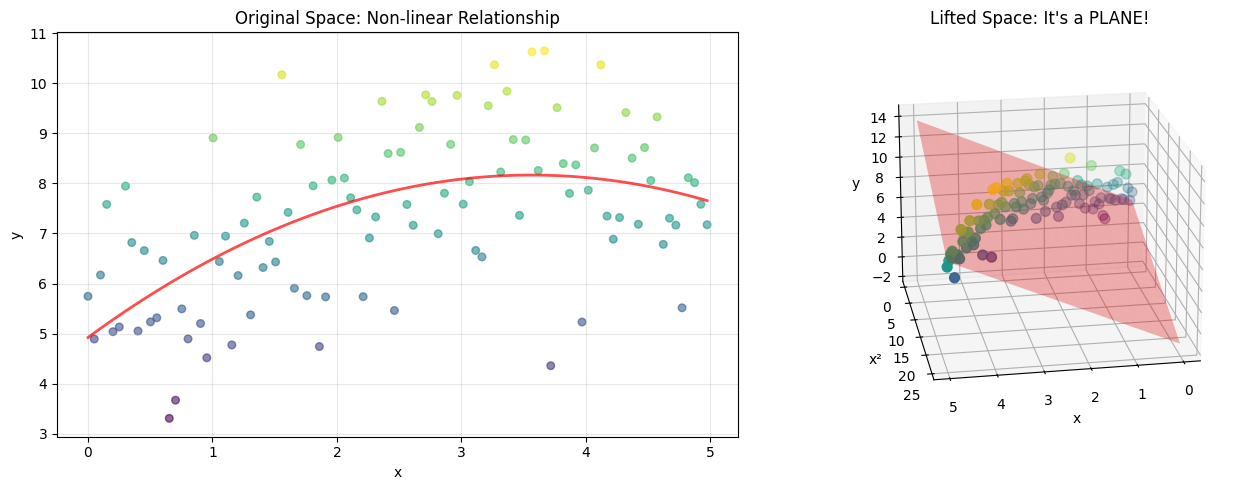

In [36]:
from mpl_toolkits.mplot3d import Axes3D

def visualize_lifting_technique():
    """Interactive 3D visualization of the lifting technique"""
    
    fig = plt.figure(figsize=(14, 5))
    
    # Use subset for clarity
    X_vis = X_learn[:100]
    y_vis = y_learn[:100]
    
    # Original space: curved relationship
    ax1 = fig.add_subplot(121)
    ax1.scatter(X_vis, y_vis, alpha=0.6, s=30, c=y_vis, cmap='viridis')
    ax1.set_xlabel('x')
    ax1.set_ylabel('y')
    ax1.set_title('Original Space: Non-linear Relationship')
    ax1.grid(True, alpha=0.3)
    
    # Add fitted curve
    poly_2d = Pipeline([
        ('poly', PolynomialFeatures(degree=2)),
        ('linear', LinearRegression())
    ])
    poly_2d.fit(X_vis.reshape(-1, 1), y_vis)
    x_line = np.linspace(X_vis.min(), X_vis.max(), 100).reshape(-1, 1)
    ax1.plot(x_line, poly_2d.predict(x_line), 'r-', linewidth=2, alpha=0.7)
    
    # Lifted space: now it's a plane!
    ax2 = fig.add_subplot(122, projection='3d')
    X_squared = X_vis**2
    ax2.scatter(X_vis, X_squared, y_vis, c=y_vis, cmap='viridis', s=50)
    
    # Fit plane in lifted space
    X_lifted = np.column_stack([X_vis, X_squared])
    model_lifted = LinearRegression().fit(X_lifted, y_vis)
    
    # Visualize the fitted plane
    x_mesh = np.linspace(X_vis.min(), X_vis.max(), 20)
    x2_mesh = np.linspace(X_squared.min(), X_squared.max(), 20)
    X_mesh, X2_mesh = np.meshgrid(x_mesh, x2_mesh)
    Y_plane = model_lifted.intercept_ + model_lifted.coef_[0]*X_mesh + model_lifted.coef_[1]*X2_mesh
    
    ax2.plot_surface(X_mesh, X2_mesh, Y_plane, alpha=0.3, color='red')
    ax2.set_xlabel('x')
    ax2.set_ylabel('x²')
    ax2.set_zlabel('y')
    ax2.set_title('Lifted Space: It\'s a PLANE!')
    ax2.view_init(elev=20, azim=80)
    
    plt.tight_layout()
    plt.show()
    
    

visualize_lifting_technique()

### Key Insight

By adding $x^2$ as a new dimension, curves become planes.  

This is why polynomial regression is still “linear” regression.

#### Equations
- Original space (quadratic model):
$$
y = \theta_0 + \theta_1 x + \theta_2 x^2
$$

- Lifted space (linear in features x₁, x₂):
$$
y = \beta_0 + \beta_1 x_1 + \beta_2 x_2
$$

(where $x_1 = x$ and $x_2 = x^2$)

# Part 5: Real-World Application - Weather Forecasting

## Applying Polynomial Regression to Weather Data

Now let's apply what we've learned to the weather forecasting problem we loaded at the beginning. We'll use the ECMWF data to show how polynomial regression is used operationally to correct systematic biases in numerical weather prediction models.

### Using Our Previously Loaded Data

In [37]:
# We already loaded the weather data in Part 1, let's use it now
print(f"Using weather dataset loaded earlier: {len(forecast_error):,} observations")
print(f"Sample size for training: {len(X_weather):,} observations")
print(f"Baseline RMSE: {baseline_rmse:.3f}°C")

# Split the sampled weather data for proper evaluation
X_train_weather, X_test_weather, y_train_weather, y_test_weather = train_test_split(
    X_weather, y_weather, test_size=0.2, random_state=42
)

print(f"\nTraining on {len(X_train_weather):,} observations")
print(f"Testing on {len(X_test_weather):,} observations")

Using weather dataset loaded earlier: 5,265,488 observations
Sample size for training: 50,000 observations
Baseline RMSE: 2.254°C

Training on 40,000 observations
Testing on 10,000 observations


### Comparing Different Polynomial Degrees

Just as we experimented with different degrees on our synthetic data, let's systematically test which polynomial degree works best for the weather bias correction problem. This mirrors the actual research process that led to ECMWF's operational choice of cubic polynomials.

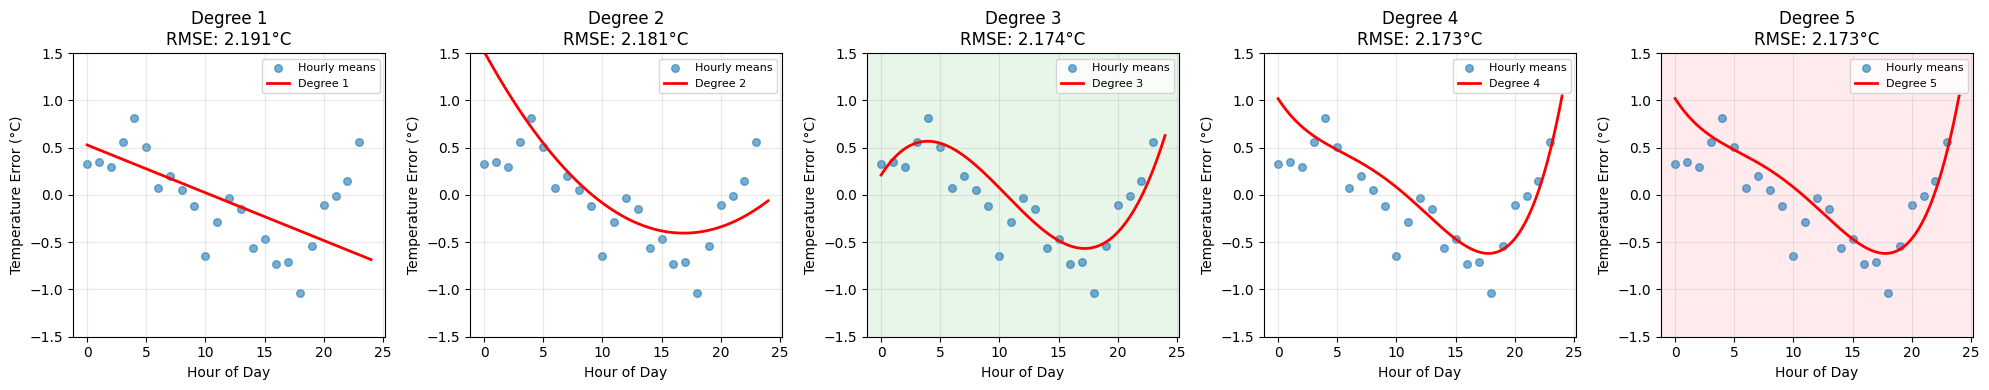


Polynomial Degree Comparison for Weather Data:
Degree | Test RMSE | Improvement over baseline
-------|-----------|-------------------------
   1   | 2.1906°C | +0.90%
   2   | 2.1812°C | +1.33%
   3   | 2.1745°C | +1.63%
   4   | 2.1731°C | +1.69%
   5   | 2.1731°C | +1.69%

Optimal degree: 4


In [38]:
# Test different polynomial degrees on weather data
degrees_to_test = [1, 2, 3, 4, 5]
weather_results = []

fig, axes = plt.subplots(1, len(degrees_to_test), figsize=(20, 4))

for idx, degree in enumerate(degrees_to_test):
    # Create and train model
    poly_weather_model = Pipeline([
        ('poly', PolynomialFeatures(degree=degree)),
        ('linear', LinearRegression())
    ])
    poly_weather_model.fit(X_train_weather, y_train_weather)
    
    # Evaluate
    predictions = poly_weather_model.predict(X_test_weather)
    test_rmse = np.sqrt(metrics.mean_squared_error(y_test_weather, predictions))
    weather_results.append((degree, test_rmse))
    
    # Visualize
    ax = axes[idx]
    
    # Show hourly means for reference
    hours = np.arange(0, 24, 1)
    hourly_means = []
    for hour in hours:
        mask = (X_test_weather.flatten() >= hour) & (X_test_weather.flatten() < hour + 1)
        if np.sum(mask) > 0:
            hourly_means.append(np.mean(y_test_weather[mask]))
        else:
            hourly_means.append(0)
    
    ax.scatter(hours, hourly_means, alpha=0.6, s=30, label='Hourly means')
    
    # Plot polynomial fit
    x_smooth = np.linspace(0, 24, 200).reshape(-1, 1)
    y_smooth = poly_weather_model.predict(x_smooth)
    ax.plot(x_smooth, y_smooth, 'r-', linewidth=2, label=f'Degree {degree}')
    
    ax.set_xlabel('Hour of Day')
    ax.set_ylabel('Temperature Error (°C)')
    ax.set_title(f'Degree {degree}\nRMSE: {test_rmse:.3f}°C')
    ax.set_ylim([-1.5, 1.5])
    ax.grid(True, alpha=0.3)
    ax.legend(fontsize=8)
    
    # Color code by performance
    if degree == 3:
        ax.set_facecolor('#E8F5E9')  # Green for optimal
    elif degree > 4:
        ax.set_facecolor('#FFEBEE')  # Red for overfitting risk

plt.tight_layout()
plt.show()

# Display results table
print("\nPolynomial Degree Comparison for Weather Data:")
print("Degree | Test RMSE | Improvement over baseline")
print("-------|-----------|-------------------------")
baseline_sample_rmse = np.sqrt(np.mean(y_test_weather**2))
for degree, rmse in weather_results:
    improvement = (baseline_sample_rmse - rmse) / baseline_sample_rmse * 100
    print(f"   {degree}   | {rmse:.4f}°C | {improvement:+.2f}%")

optimal_degree = min(weather_results, key=lambda x: x[1])[0]
print(f"\nOptimal degree: {optimal_degree}")

### ECMWF's Operational Implementation

ECMWF chose degree 3 (cubic) polynomials based on extensive validation. This degree captures the asymmetric nature of daily temperature cycles - rapid morning warming and slower evening cooling - without overfitting to noise. Let's implement their exact approach:


ECMWF Operational Model:
  Equation: y = 0.2103 + 0.19684t + -0.0307488t² + 0.000969700t³
  Test RMSE: 2.1745°C
  Improvement: 1.63%


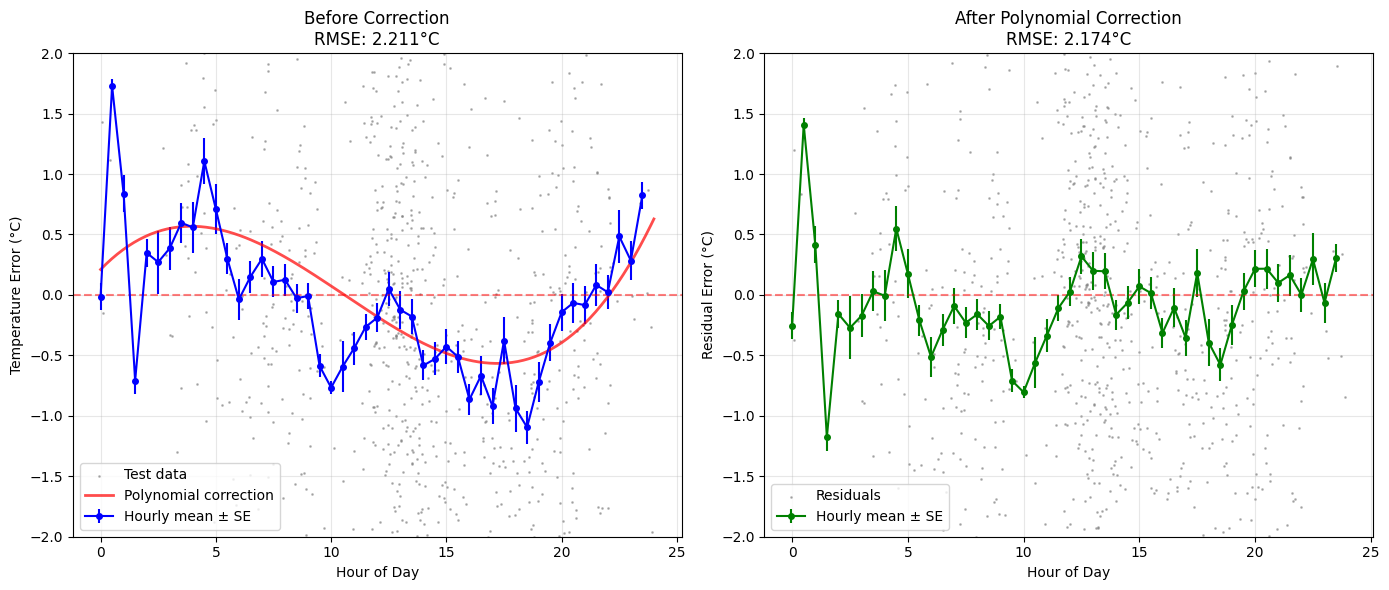


Pattern Analysis:
Before correction - mean bias by time of day ranges from -1.095 to 1.728°C
After correction - residual bias ranges from -1.176 to 1.408°C
Variance reduction: 2.6%


In [43]:
# Implement ECMWF's actual approach: cubic (degree 3) with manual feature creation
# This matches their operational system

# 1) Create polynomial features manually (t, t^2, t^3)
t_train = X_train_weather.reshape(-1)  # ensure 1D
t_test  = X_test_weather.reshape(-1)

X_train_cubic_manual = np.c_[t_train, t_train**2, t_train**3]
X_test_cubic_manual  = np.c_[t_test,  t_test**2,  t_test**3]

# 2) Train model (ensure y is 1D)
ecmwf_model = LinearRegression()
ecmwf_model.fit(X_train_cubic_manual, y_train_weather.ravel())

# 3) Extract coefficients (flatten to 1D)
c0 = float(ecmwf_model.intercept_)
c1, c2, c3 = ecmwf_model.coef_.ravel()

# 4) Evaluate
ecmwf_predictions = ecmwf_model.predict(X_test_cubic_manual)
ecmwf_rmse = np.sqrt(metrics.mean_squared_error(y_test_weather, ecmwf_predictions))

print("ECMWF Operational Model:")
print(f"  Equation: y = {c0:.4f} + {c1:.5f}t + {c2:.7f}t² + {c3:.9f}t³")
print(f"  Test RMSE: {ecmwf_rmse:.4f}°C")
print(f"  Improvement: {(baseline_sample_rmse - ecmwf_rmse)/baseline_sample_rmse*100:.2f}%")

# Better visualization that actually shows the patterns
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Before correction - show actual data distribution
axes[0].scatter(X_test_weather.flatten()[::10], y_test_weather[::10], 
                alpha=0.5, s=1, color='gray', label='Test data')

# Calculate and plot hourly means to show the pattern
hours = np.arange(0, 24, 0.5)
mean_before = []
std_before = []
for hour in hours:
    mask = (X_test_weather.flatten() >= hour) & (X_test_weather.flatten() < hour + 0.5)
    if mask.sum() > 0:
        mean_before.append(np.mean(y_test_weather[mask]))
        std_before.append(np.std(y_test_weather[mask]))
    else:
        mean_before.append(0)
        std_before.append(0)

axes[0].errorbar(hours, mean_before, yerr=np.array(std_before)/np.sqrt(len(y_test_weather)/48), 
                 fmt='o-', color='blue', markersize=4, label='Hourly mean ± SE')
axes[0].axhline(0, color='red', linestyle='--', alpha=0.5)
axes[0].set_xlabel('Hour of Day')
axes[0].set_ylabel('Temperature Error (°C)')
axes[0].set_title(f'Before Correction\nRMSE: {baseline_sample_rmse:.3f}°C')
axes[0].set_ylim([-2, 2])
axes[0].grid(True, alpha=0.3)
axes[0].legend()

# After correction - show residuals
residuals = y_test_weather.flatten() - ecmwf_predictions.flatten()
axes[1].scatter(X_test_weather.flatten()[::10], residuals[::10], 
                alpha=0.5, s=1, color='gray', label='Residuals')

# Calculate hourly means of residuals
mean_after = []
std_after = []
for hour in hours:
    mask = (X_test_weather.flatten() >= hour) & (X_test_weather.flatten() < hour + 0.5)
    if mask.sum() > 0:
        mean_after.append(np.mean(residuals[mask]))
        std_after.append(np.std(residuals[mask]))
    else:
        mean_after.append(0)
        std_after.append(0)

axes[1].errorbar(hours, mean_after, yerr=np.array(std_after)/np.sqrt(len(residuals)/48), 
                 fmt='o-', color='green', markersize=4, label='Hourly mean ± SE')
axes[1].axhline(0, color='red', linestyle='--', alpha=0.5)
axes[1].set_xlabel('Hour of Day')
axes[1].set_ylabel('Residual Error (°C)')
axes[1].set_title(f'After Polynomial Correction\nRMSE: {ecmwf_rmse:.3f}°C')
axes[1].set_ylim([-2, 2])
axes[1].grid(True, alpha=0.3)
axes[1].legend()

# Add the polynomial correction curve to the first plot to show what we're correcting
x_smooth = np.linspace(0, 24, 200)
y_correction = c0 + c1*x_smooth + c2*x_smooth**2 + c3*x_smooth**3
axes[0].plot(x_smooth, y_correction, 'r-', linewidth=2, alpha=0.7, label='Polynomial correction')
axes[0].legend()

plt.tight_layout()
plt.show()

# Print diagnostic information
print(f"\nPattern Analysis:")
print(f"Before correction - mean bias by time of day ranges from {min(mean_before):.3f} to {max(mean_before):.3f}°C")
print(f"After correction - residual bias ranges from {min(mean_after):.3f} to {max(mean_after):.3f}°C")
print(f"Variance reduction: {(np.var(y_test_weather) - np.var(residuals))/np.var(y_test_weather)*100:.1f}%")

# Part 6: When Models Go Wrong - Overfitting

## Interactive Overfitting Demonstration

In [44]:
def demonstrate_overfitting(n_points=30, degree=2):
    """Interactive demonstration of overfitting"""
    
    # Use limited training data
    X_small = X_train[:n_points]
    y_small = y_train[:n_points]
    
    # Fit polynomial model
    poly_model = Pipeline([
        ('poly', PolynomialFeatures(degree=degree)),
        ('linear', LinearRegression())
    ])
    poly_model.fit(X_small, y_small)
    
    # Calculate metrics
    train_score = poly_model.score(X_small, y_small)
    test_score = poly_model.score(X_test, y_test)
    n_features = degree + 1
    
    # Create visualization
    fig, axes = plt.subplots(1, 2, figsize=(12, 5))
    
    # Fit visualization
    axes[0].scatter(X_small, y_small, s=80, alpha=0.7, zorder=3, 
                   label=f'Training ({n_points} points)', color='blue')
    axes[0].scatter(X_test, y_test, s=10, alpha=0.2, color='gray', label='Test data')
    
    X_plot = np.linspace(-0.5, 10.5, 300).reshape(-1, 1)
    y_pred = poly_model.predict(X_plot)
    
    axes[0].plot(X_plot, y_pred, 'r-', linewidth=2, label=f'Degree {degree}')
    axes[0].set_ylim([-10, 20])
    axes[0].set_xlim([-0.5, 10.5])
    axes[0].set_xlabel('x')
    axes[0].set_ylabel('y')
    axes[0].set_title(f'Polynomial Fit (Degree {degree})')
    axes[0].legend(loc='upper right')
    axes[0].grid(True, alpha=0.3)
    
    # Performance metrics
    metrics_data = ['Train R²', 'Test R²', 'Overfit Gap']
    values = [train_score, max(0, test_score), max(0, train_score - test_score)]
    colors_bar = ['blue', 'orange', 'red']
    
    bars = axes[1].bar(metrics_data, values, color=colors_bar)
    axes[1].set_ylim([0, 1.2])
    axes[1].set_title('Model Performance')
    axes[1].axhline(y=0.8, color='green', linestyle='--', alpha=0.5, label='Good performance')
    axes[1].legend()
    
    # Add value labels
    for bar, value in zip(bars, values):
        axes[1].text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.02,
                    f'{value:.3f}', ha='center', va='bottom')
    
    # Status indicator
    data_per_param = n_points / n_features
    if test_score < 0.3 or train_score - test_score > 0.3:
        status = "⚠️ Severe overfitting!"
        fig.patch.set_facecolor('#FFEBEE')
    elif train_score - test_score > 0.15:
        status = "⚡ Overfitting detected"
        fig.patch.set_facecolor('#FFF3E0')
    else:
        status = "✅ Good balance"
        fig.patch.set_facecolor('#E8F5E9')
    
    plt.suptitle(f'{status} | Parameters: {n_features} | Data/Parameter Ratio: {data_per_param:.1f}')
    plt.tight_layout()
    plt.show()
    
    if degree > n_points // 5:
        print(f"⚠️ Warning: With {n_points} points and degree {degree}, you have {n_features} parameters.")
        print("Rule of thumb: You need at least 5-10 data points per parameter!")

# Interactive widget
print("🔬 Experiment with overfitting:")
print("Try high degree with few points to see severe overfitting!\n")
interact(demonstrate_overfitting,
         degree=IntSlider(min=1, max=15, step=1, value=2, description='Degree:'),
         n_points=IntSlider(min=10, max=100, step=10, value=30, description='Training Points:'))

🔬 Experiment with overfitting:
Try high degree with few points to see severe overfitting!



interactive(children=(IntSlider(value=30, description='Training Points:', min=10, step=10), IntSlider(value=2,…

<function __main__.demonstrate_overfitting(n_points=30, degree=2)>

# Part 7: Feature Engineering - Beyond Simple Polynomials

## Domain Knowledge Beats Brute Force

While polynomial features are powerful, domain-specific feature engineering often yields better results with fewer parameters, reducing overfitting risk. Let's explore how physics and mathematics can guide better feature creation.

### Physics-Informed Features for Automotive Data

Instead of blindly adding polynomial terms, let's use automotive physics:

In [51]:
# Load the auto data again for feature engineering
from mlxtend.data import autompg_data
X_auto, y_auto = autompg_data()

# Correct column names (8 columns)
df_auto = pd.DataFrame(X_auto, columns=['displacement', 'cylinders', 'horsepower', 'weight', 
                                        'acceleration', 'model_year', 'origin_1', 'origin_2'])
df_auto['mpg'] = y_auto

# Create physics-informed features
df_auto['power_weight_ratio'] = df_auto['horsepower'] / df_auto['weight']  # Better: use actual power
df_auto['inverse_displacement'] = 1 / df_auto['displacement']  # Reciprocal for efficiency
df_auto['weight_squared'] = df_auto['weight'] ** 2  # Quadratic drag effects

# Compare models
from sklearn.preprocessing import StandardScaler

# Model 1: Simple polynomial on displacement
X_poly_simple = PolynomialFeatures(degree=3).fit_transform(df_auto[['displacement']])

# Model 2: Physics-informed features (now including horsepower)
X_physics = df_auto[['displacement', 'weight', 'horsepower', 'power_weight_ratio', 'inverse_displacement']].values
X_physics = StandardScaler().fit_transform(X_physics)  # Scale for fair comparison

# Split and evaluate both
X_train_poly, X_test_poly, y_train, y_test = train_test_split(X_poly_simple, y_auto, test_size=0.2, random_state=42)
X_train_phys, X_test_phys, _, _ = train_test_split(X_physics, y_auto, test_size=0.2, random_state=42)

model_poly = LinearRegression().fit(X_train_poly, y_train)
model_physics = LinearRegression().fit(X_train_phys, y_train)

rmse_poly = np.sqrt(metrics.mean_squared_error(y_test, model_poly.predict(X_test_poly)))
rmse_physics = np.sqrt(metrics.mean_squared_error(y_test, model_physics.predict(X_test_phys)))

print("\nModel Comparison:")
print(f"Polynomial (degree 3): {X_poly_simple.shape[1]} features, RMSE = {rmse_poly:.2f} MPG")
print(f"Physics-informed: {X_physics.shape[1]} features, RMSE = {rmse_physics:.2f} MPG")
print(f"Physics features are {improvement:.1f}% better with more interpretable features.")


Model Comparison:
Polynomial (degree 3): 4 features, RMSE = 4.40 MPG
Physics-informed: 5 features, RMSE = 4.14 MPG
Physics features are 6.4% better with more interpretable features.



### Visualizing Feature Importance

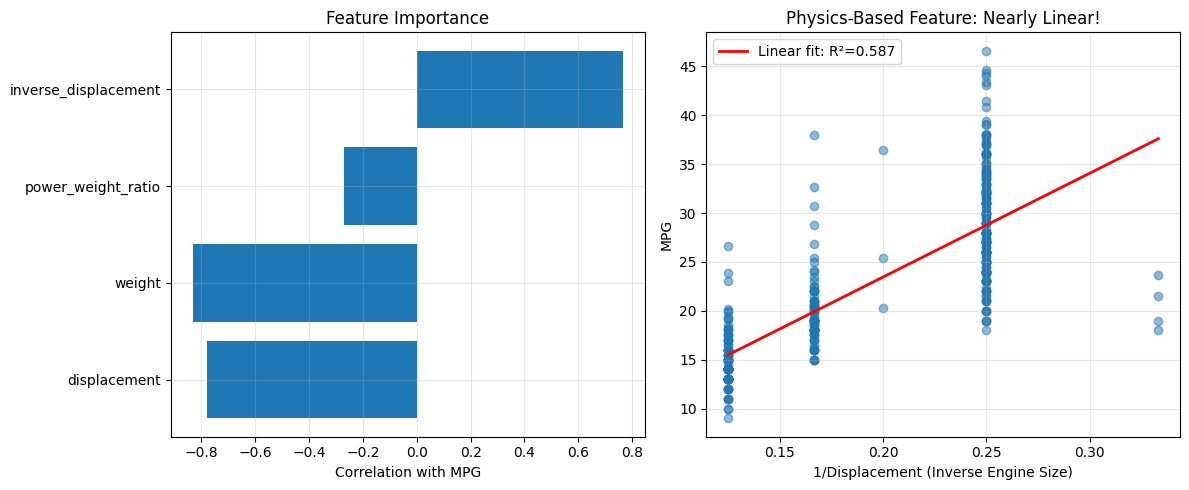

In [52]:
# Show which features matter most
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Feature correlations with MPG
correlations = df_auto[['displacement', 'weight', 'power_weight_ratio', 'inverse_displacement', 'mpg']].corr()['mpg'][:-1]
axes[0].barh(range(len(correlations)), correlations.values)
axes[0].set_yticks(range(len(correlations)))
axes[0].set_yticklabels(correlations.index)
axes[0].set_xlabel('Correlation with MPG')
axes[0].set_title('Feature Importance')
axes[0].grid(True, alpha=0.3)

# Scatter plot of best engineered feature
axes[1].scatter(df_auto['inverse_displacement'], df_auto['mpg'], alpha=0.5)
axes[1].set_xlabel('1/Displacement (Inverse Engine Size)')
axes[1].set_ylabel('MPG')
axes[1].set_title('Physics-Based Feature: Nearly Linear!')
axes[1].grid(True, alpha=0.3)

# Add regression line
z = np.polyfit(df_auto['inverse_displacement'], df_auto['mpg'], 1)
p = np.poly1d(z)
x_line = np.linspace(df_auto['inverse_displacement'].min(), df_auto['inverse_displacement'].max(), 100)
axes[1].plot(x_line, p(x_line), "r-", linewidth=2, label=f'Linear fit: R²={metrics.r2_score(df_auto["mpg"], p(df_auto["inverse_displacement"])):.3f}')
axes[1].legend()

plt.tight_layout()
plt.show()

## Capturing Discontinuities: The Frozen Soil Example

Weather models need to handle the phase transition at 0°C, where water freezes and heat transfer changes dramatically:

soil_temperature.csv:   0%|          | 0.00/87.8M [00:00<?, ?B/s]

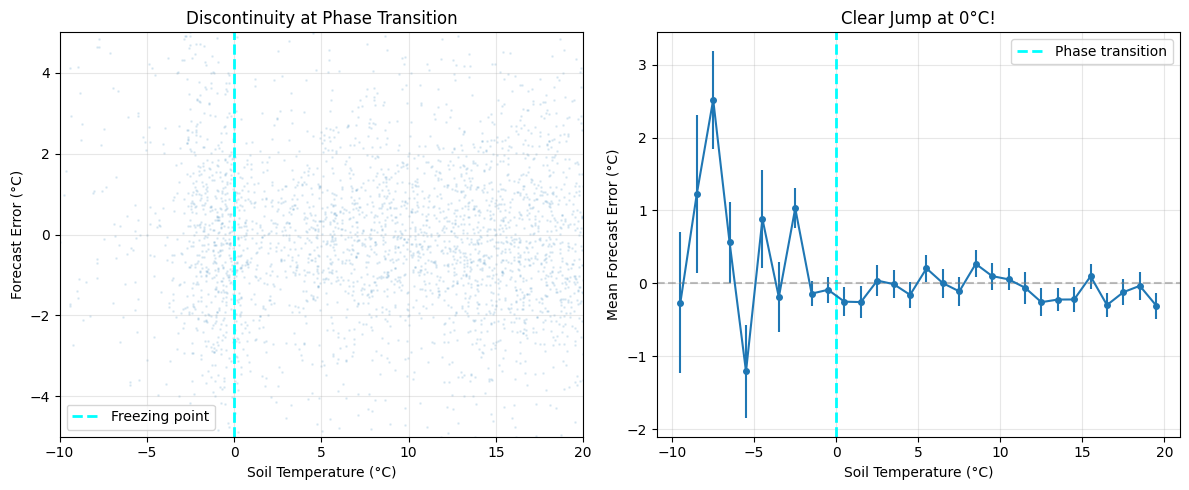

Error difference across freezing point: 0.603°C
A simple binary feature captures this complex physics!


In [53]:
# Load soil temperature data (if not already loaded)
if 'soil_temperature' not in locals():
    soil_temperature = cml.load_dataset(
        'mltc-surface-observation-postprocessing',
        field='soil_temperature'
    ).to_numpy()

# Sample for visualization
sample_idx = np.random.choice(len(forecast_error), 5000, replace=False)
soil_temp_sample = soil_temperature[sample_idx]
error_sample = forecast_error[sample_idx]

# Create frozen indicator
soil_frozen = (soil_temp_sample < 0).astype(float)

# Visualize the discontinuity
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Raw relationship
axes[0].scatter(soil_temp_sample, error_sample, alpha=0.1, s=1)
axes[0].axvline(0, color='cyan', linestyle='--', linewidth=2, label='Freezing point')
axes[0].set_xlabel('Soil Temperature (°C)')
axes[0].set_ylabel('Forecast Error (°C)')
axes[0].set_title('Discontinuity at Phase Transition')
axes[0].set_xlim([-10, 20])
axes[0].set_ylim([-5, 5])
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Binned means to show the jump
bins = np.linspace(-10, 20, 31)
bin_centers = (bins[:-1] + bins[1:]) / 2
bin_means = []
bin_stds = []

for i in range(len(bins)-1):
    mask = (soil_temp_sample >= bins[i]) & (soil_temp_sample < bins[i+1])
    if mask.sum() > 0:
        bin_means.append(np.mean(error_sample[mask]))
        bin_stds.append(np.std(error_sample[mask]) / np.sqrt(mask.sum()))
    else:
        bin_means.append(np.nan)
        bin_stds.append(np.nan)

axes[1].errorbar(bin_centers, bin_means, yerr=bin_stds, fmt='o-', markersize=4)
axes[1].axvline(0, color='cyan', linestyle='--', linewidth=2, label='Phase transition')
axes[1].axhline(0, color='gray', linestyle='--', alpha=0.5)
axes[1].set_xlabel('Soil Temperature (°C)')
axes[1].set_ylabel('Mean Forecast Error (°C)')
axes[1].set_title('Clear Jump at 0°C!')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print(f"Error difference across freezing point: {np.mean(error_sample[soil_frozen==1]) - np.mean(error_sample[soil_frozen==0]):.3f}°C")
print("A simple binary feature captures this complex physics!")


## Periodic Features for Cyclic Data

For daily cycles, periodic functions are superior to polynomials because they naturally enforce continuity:

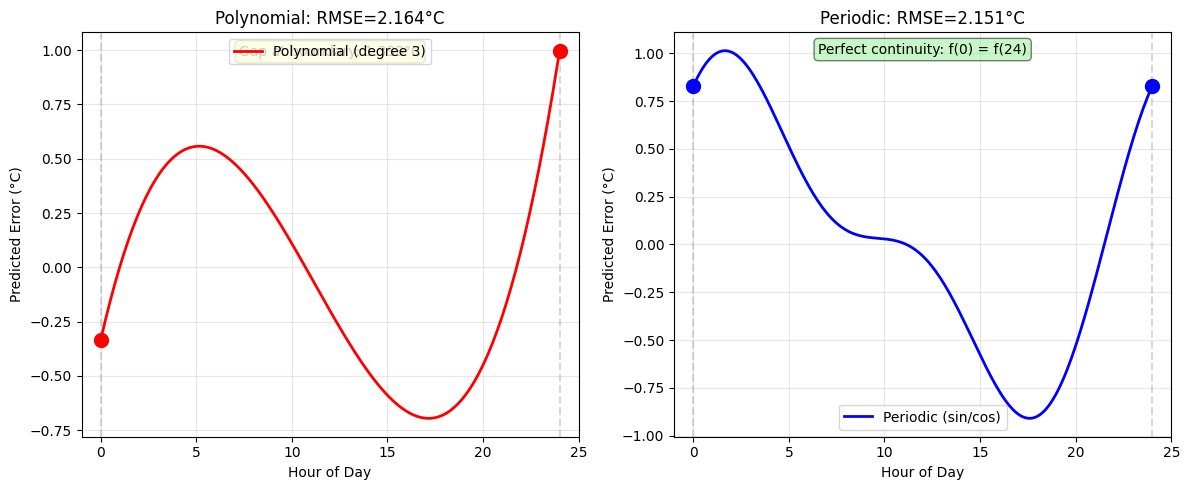

In [58]:
# Compare polynomial vs periodic features for time of day
time_sample = time_of_day[sample_idx]

# Create feature sets
# Polynomial features
time_poly = np.column_stack([time_sample, time_sample**2, time_sample**3])

# Periodic features (Fourier basis)
time_periodic = np.column_stack([
    np.sin(2*np.pi*time_sample/24),  # Daily cycle
    np.cos(2*np.pi*time_sample/24),
    np.sin(4*np.pi*time_sample/24),  # Semi-daily cycle  
    np.cos(4*np.pi*time_sample/24)
])

# Split and train
X_train_poly, X_test_poly, y_train, y_test = train_test_split(time_poly, error_sample, test_size=0.2, random_state=42)
X_train_periodic, X_test_periodic, _, _ = train_test_split(time_periodic, error_sample, test_size=0.2, random_state=42)

model_poly_time = LinearRegression().fit(X_train_poly, y_train)
model_periodic = LinearRegression().fit(X_train_periodic, y_train)

# Evaluate
rmse_poly_time = np.sqrt(metrics.mean_squared_error(y_test, model_poly_time.predict(X_test_poly)))
rmse_periodic = np.sqrt(metrics.mean_squared_error(y_test, model_periodic.predict(X_test_periodic)))

# Visualize predictions
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Generate smooth predictions
t_smooth = np.linspace(0, 24, 200)
t_poly_smooth = np.column_stack([t_smooth, t_smooth**2, t_smooth**3])
t_periodic_smooth = np.column_stack([
    np.sin(2*np.pi*t_smooth/24),
    np.cos(2*np.pi*t_smooth/24),
    np.sin(4*np.pi*t_smooth/24),
    np.cos(4*np.pi*t_smooth/24)
])

pred_poly = model_poly_time.predict(t_poly_smooth)
pred_periodic = model_periodic.predict(t_periodic_smooth)

# Polynomial approach
axes[0].plot(t_smooth, pred_poly, 'r-', linewidth=2, label='Polynomial (degree 3)')
axes[0].scatter([0, 24], [pred_poly[0], pred_poly[-1]], s=100, c='red', zorder=5)
axes[0].set_xlabel('Hour of Day')
axes[0].set_ylabel('Predicted Error (°C)')
axes[0].set_title(f'Polynomial: RMSE={rmse_poly_time:.3f}°C')
axes[0].set_xlim([-1, 25])
axes[0].axvline(0, color='gray', linestyle='--', alpha=0.3)
axes[0].axvline(24, color='gray', linestyle='--', alpha=0.3)
axes[0].legend()
axes[0].grid(True, alpha=0.3)
# Fix the scalar extraction
axes[0].text(12, axes[0].get_ylim()[1]*0.9, 
            f'Gap at boundary: {abs(float(pred_poly[0]) - float(pred_poly[-1])):.3f}°C',
            ha='center', bbox=dict(boxstyle='round', facecolor='yellow', alpha=0.5))

# Periodic approach
axes[1].plot(t_smooth, pred_periodic, 'b-', linewidth=2, label='Periodic (sin/cos)')
axes[1].scatter([0, 24], [pred_periodic[0], pred_periodic[-1]], s=100, c='blue', zorder=5)
axes[1].set_xlabel('Hour of Day')
axes[1].set_ylabel('Predicted Error (°C)')
axes[1].set_title(f'Periodic: RMSE={rmse_periodic:.3f}°C')
axes[1].set_xlim([-1, 25])
axes[1].axvline(0, color='gray', linestyle='--', alpha=0.3)
axes[1].axvline(24, color='gray', linestyle='--', alpha=0.3)
axes[1].legend()
axes[1].grid(True, alpha=0.3)
axes[1].text(12, axes[1].get_ylim()[1]*0.9, 
            f'Perfect continuity: f(0) = f(24)',
            ha='center', bbox=dict(boxstyle='round', facecolor='lightgreen', alpha=0.5))

plt.tight_layout()
plt.show()



## Key Advantages of Periodic Features

1. Guaranteed continuity: f(0) = f(24)
2. No extrapolation issues beyond [0, 24]
3. Fewer parameters (4 vs polynomial degree)
4. Based on physical understanding of daily cycles


### Feature Engineering Summary

| Problem | Naive Approach | Smart Features | Why Better |
|---------|---------------|----------------|------------|
| Auto MPG | displacement³ | 1/displacement | Physics: efficiency ∝ 1/size |
| Weather Time | t, t², t³ | sin(2πt/24), cos(2πt/24) | Enforces periodicity |
| Soil Effects | soil_temp² | I(soil_temp < 0) | Captures phase transition |

### Key Takeaways

1. **Domain knowledge > More parameters**: Understanding the physics/mathematics of your problem leads to better features
2. **Discontinuities need special handling**: Binary indicators for phase transitions, thresholds
3. **Periodic data needs periodic functions**: Sine/cosine for cycles, not polynomials
4. **Fewer, better features reduce overfitting**: Smart engineering beats brute force

This is how real ML systems are built - not by blindly adding polynomial terms, but by understanding the problem domain and creating features that capture the true underlying patterns.

# Key Takeaways

## Core Concepts

1. **Linear Regression Universality**
   - Same algorithm solves diverse non-linear problems
   - "Linear" refers to parameters, not input-output relationship
   - Polynomial features transform curves into manageable problems

2. **Understanding Through Interaction**
   - MSE measures prediction error: $\frac{1}{n}\sum(y_i - \hat{y}_i)^2$
   - Parameters (w, b) can be tuned to minimize error
   - Residual patterns reveal model limitations

3. **The Lifting Technique**
   - Transform non-linear problems into linear ones in higher dimensions
   - Curves become hyperplanes after transformation
   - Foundation for kernel methods and deep learning

4. **Model Complexity Balance**
   - Match model complexity to available data
   - Overfitting: high train performance, poor test performance
   - Need ~5-10 data points per parameter minimum

5. **Real-World Impact**
   - Small improvements × large scale = significant impact
   - ECMWF: 2-3% improvement = 46 million better predictions/year
   - Domain knowledge guides feature engineering

## Practical Guidelines

### When to Use Polynomial Features:

**Good candidates:**
- Known physical relationships (inverse square laws, periodic patterns)
- Smooth, continuous relationships
- Limited data with clear patterns
- Need for interpretable models

**Poor candidates:**
- High-dimensional data (curse of dimensionality)
- Discontinuous relationships
- Very noisy data
- When extrapolation is important

### Choosing Polynomial Degree:

1. Start simple (degree 2-3)
2. Use cross-validation to select degree
3. Monitor train vs. test performance gap
4. Consider physical interpretation
5. Remember: higher degree ≠ better model


## Quick Reference

### Polynomial Regression in scikit-learn

```python
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import Pipeline

# Method 1: Pipeline (recommended)
poly_reg = Pipeline([
    ('poly', PolynomialFeatures(degree=3)),
    ('linear', LinearRegression())
])
poly_reg.fit(X_train, y_train)
predictions = poly_reg.predict(X_test)

# Method 2: Manual transformation
poly = PolynomialFeatures(degree=3)
X_poly = poly.fit_transform(X_train)
model = LinearRegression().fit(X_poly, y_train)
predictions = model.predict(poly.transform(X_test))
```

## Final Thought

Through interactive exploration and hands-on experimentation, you've discovered that linear regression is far more powerful than its name suggests. By understanding parameter optimization, polynomial features, and the lifting technique, you now have tools to solve remarkably complex problems while maintaining interpretability.

**Remember:** The best model isn't the most complex one - it's the one that captures true patterns while generalizing well to new data. Start simple, add complexity only when needed, and always validate on test data!

# Acknowledgments

**ECMWF Weather Dataset**: European Centre for Medium-Range Weather Forecasts (ECMWF), accessed via ClimeLab `climetlab-mltc-surface-observation-postprocessing` (Apache 2.0 License). Contains 5.2M observations from 8,000+ global weather stations.

**Auto MPG Dataset**: UCI Machine Learning Repository, accessed via MLxtend. 